In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tueplots import bundles

from laurel import mdp
from oetils.plotting import init_plotting

In [20]:
W = init_plotting(latex=True)

# Compare pruning strategies

In [3]:
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5
no_prune_times = np.zeros((len(nums_parcels), num_trials))
no_prune_iterations = np.zeros((len(nums_parcels), num_trials))
just_pp_times = np.zeros((len(nums_parcels), num_trials))
just_pp_iterations = np.zeros((len(nums_parcels), num_trials))
just_cs_times = np.zeros((len(nums_parcels), num_trials))
just_cs_iterations = np.zeros((len(nums_parcels), num_trials))
prune_times = np.zeros((len(nums_parcels), num_trials))
prune_iterations = np.zeros((len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_parcels in enumerate(tqdm(nums_parcels)):
  for j in tqdm(range(num_trials), leave=False):
    num_hubs = 10  # Number of depots in the network.
    timesteps = 50  # Number of time steps.
    num_trucks_per_step = num_hubs

    # Create middle-mile environment and initialize state.
    env = mdp.MiddleMileMDP(
        num_hubs=num_hubs,
        timesteps=timesteps,
        num_trucks_per_step=num_trucks_per_step,
        max_truck_duration=5,
        num_parcels=num_parcels,
        mean_route_length=10,
        unit_weights=True,
        unit_capacities=True,
    )
    init_state, _ = env.reset(rng)

    # With pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state)

    prune_times[i, j] = time.time() - start
    prune_iterations[i, j] = iterations

    # Just parcel pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state, prune=False)

    just_pp_times[i, j] = time.time() - start
    just_pp_iterations[i, j] = iterations

    # Just step pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, prune_parcel=False)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state)

    just_cs_times[i, j] = time.time() - start
    just_cs_iterations[i, j] = iterations

    # Without pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, prune_parcel=False)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state, prune=False)

    no_prune_times[i, j] = time.time() - start
    no_prune_iterations[i, j] = iterations

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

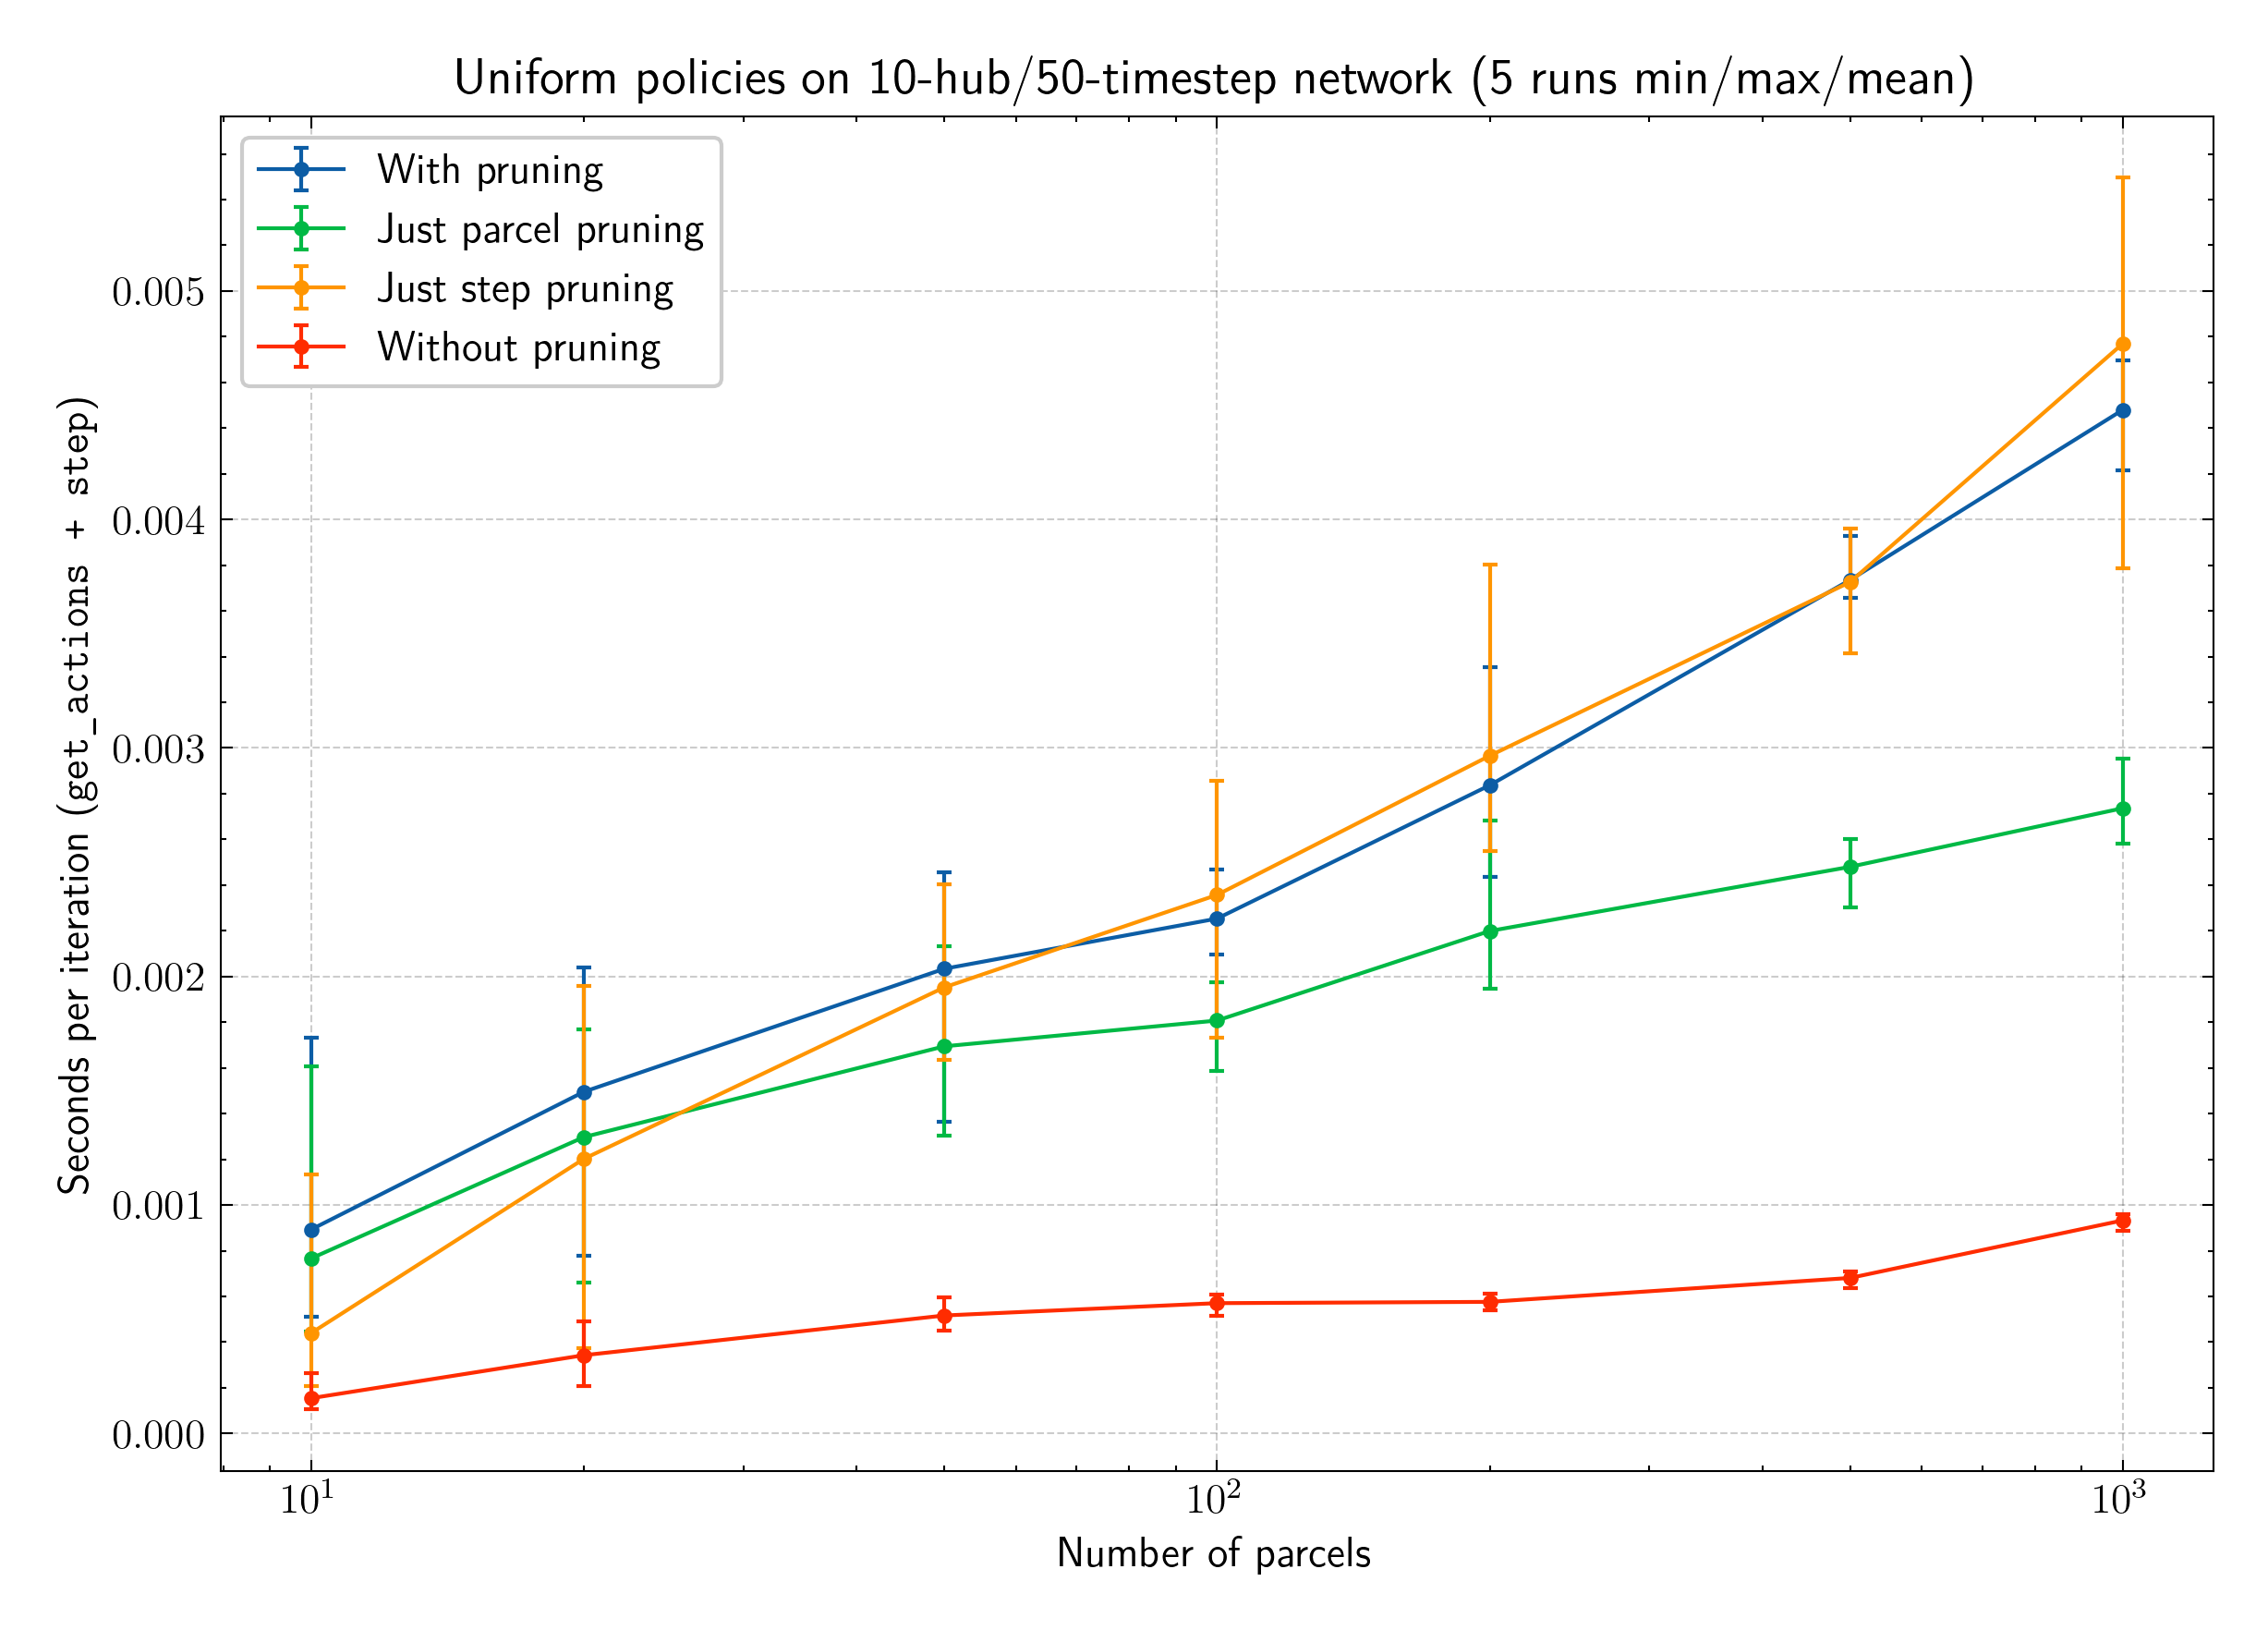

In [5]:
# Plot speeds.
fig, ax = plt.subplots()
ax.set_title("Uniform policies on 10-hub/50-timestep network (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels")
ax.set_ylabel(r"Seconds per iteration (\texttt{get_actions + step})")
ax.set_xscale('log')
prune_times[prune_times == 0] = np.nan
just_pp_times[just_pp_times == 0] = np.nan
just_cs_times[just_cs_times == 0] = np.nan
no_prune_times[no_prune_times == 0] = np.nan
prune_times_ = prune_times / prune_iterations
just_pp_times_ = just_pp_times / just_pp_iterations
just_cs_times_ = just_cs_times / just_cs_iterations
no_prune_times_ = no_prune_times / no_prune_iterations
ax.errorbar(
    nums_parcels,
    np.nanmean(prune_times_, 1),
    np.stack([
        np.nanmean(prune_times_, 1) - np.nanmin(prune_times_, 1),
        np.nanmax(prune_times_, 1) - np.nanmean(prune_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='With pruning'
)
ax.errorbar(
    nums_parcels,
    np.nanmean(just_pp_times_, 1),
    np.stack([
        np.nanmean(just_pp_times_, 1) - np.nanmin(just_pp_times_, 1), 
        np.nanmax(just_pp_times_, 1) - np.nanmean(just_pp_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='Just parcel pruning'
)
ax.errorbar(
    nums_parcels,
    np.nanmean(just_cs_times_, 1),
    np.stack([
        np.nanmean(just_cs_times_, 1) - np.nanmin(just_cs_times_, 1), 
        np.nanmax(just_cs_times_, 1) - np.nanmean(just_cs_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='Just step pruning'
)
ax.errorbar(
    nums_parcels,
    np.nanmean(no_prune_times_, 1),
    np.stack([
        np.nanmean(no_prune_times_, 1) - np.nanmin(no_prune_times_, 1), 
        np.nanmax(no_prune_times_, 1) - np.nanmean(no_prune_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='Without pruning')
ax.legend()

# Greedy vs. Random policies

In [8]:
nums_hubs = [5, 10, 20, 50]
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5
random_perf = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
greedy_perf = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
times = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
iterations = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_hubs in enumerate(tqdm(nums_hubs)):
  for j, num_parcels in enumerate(tqdm(nums_parcels, leave=False)):
    for k in range(num_trials):
      timesteps = 50
      num_trucks_per_step = num_hubs

      # Create middle-mile environment and initialize state.
      env = mdp.MiddleMileMDP(
          num_hubs=num_hubs,
          timesteps=timesteps,
          num_trucks_per_step=num_trucks_per_step,
          max_truck_duration=5,
          num_parcels=num_parcels,
          mean_route_length=10,
          unit_weights=True,
          unit_capacities=True,
      )
      init_state, _ = env.reset(rng)

      # Random
      start = time.time()
      state = init_state
      steps = 0
      deliveries = 0
      while True:
        steps += 1
        # Get next parcel and available trucks.
        state, parcel, trucks = env.get_actions(state, prune_parcel=False)
        if parcel is None:
          break

        # Put parcel onto random truck, get next state.
        truck = rng.choice(trucks)
        state, delivery, _ = env.step(parcel, truck, state, prune=False)
        deliveries += delivery

      times[i, j, k] = time.time() - start
      iterations[i, j, k] = steps
      random_perf[i, j, k] = deliveries / num_parcels

      # Greedy
      state = init_state
      deliveries = 0
      while True:
        # Get next parcel and available trucks.
        state, feature_graph, parcel, trucks = env.get_feature_graph(
          1, state, min_phantom_weight=None, prune_parcel=False
        )
        if parcel is None:
          break
        parcel = parcel[0]

        # Put parcel truck, get next state.
        truck_ids = list(trucks.keys())
        truck = trucks[truck_ids[np.argmin(
          feature_graph.nodes[feature_graph.receivers[truck_ids]][:, 2]
        )]]
        state, delivery, _ = env.step(parcel, truck, state, prune=False)
        deliveries += delivery

      greedy_perf[i, j, k] = deliveries / num_parcels

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

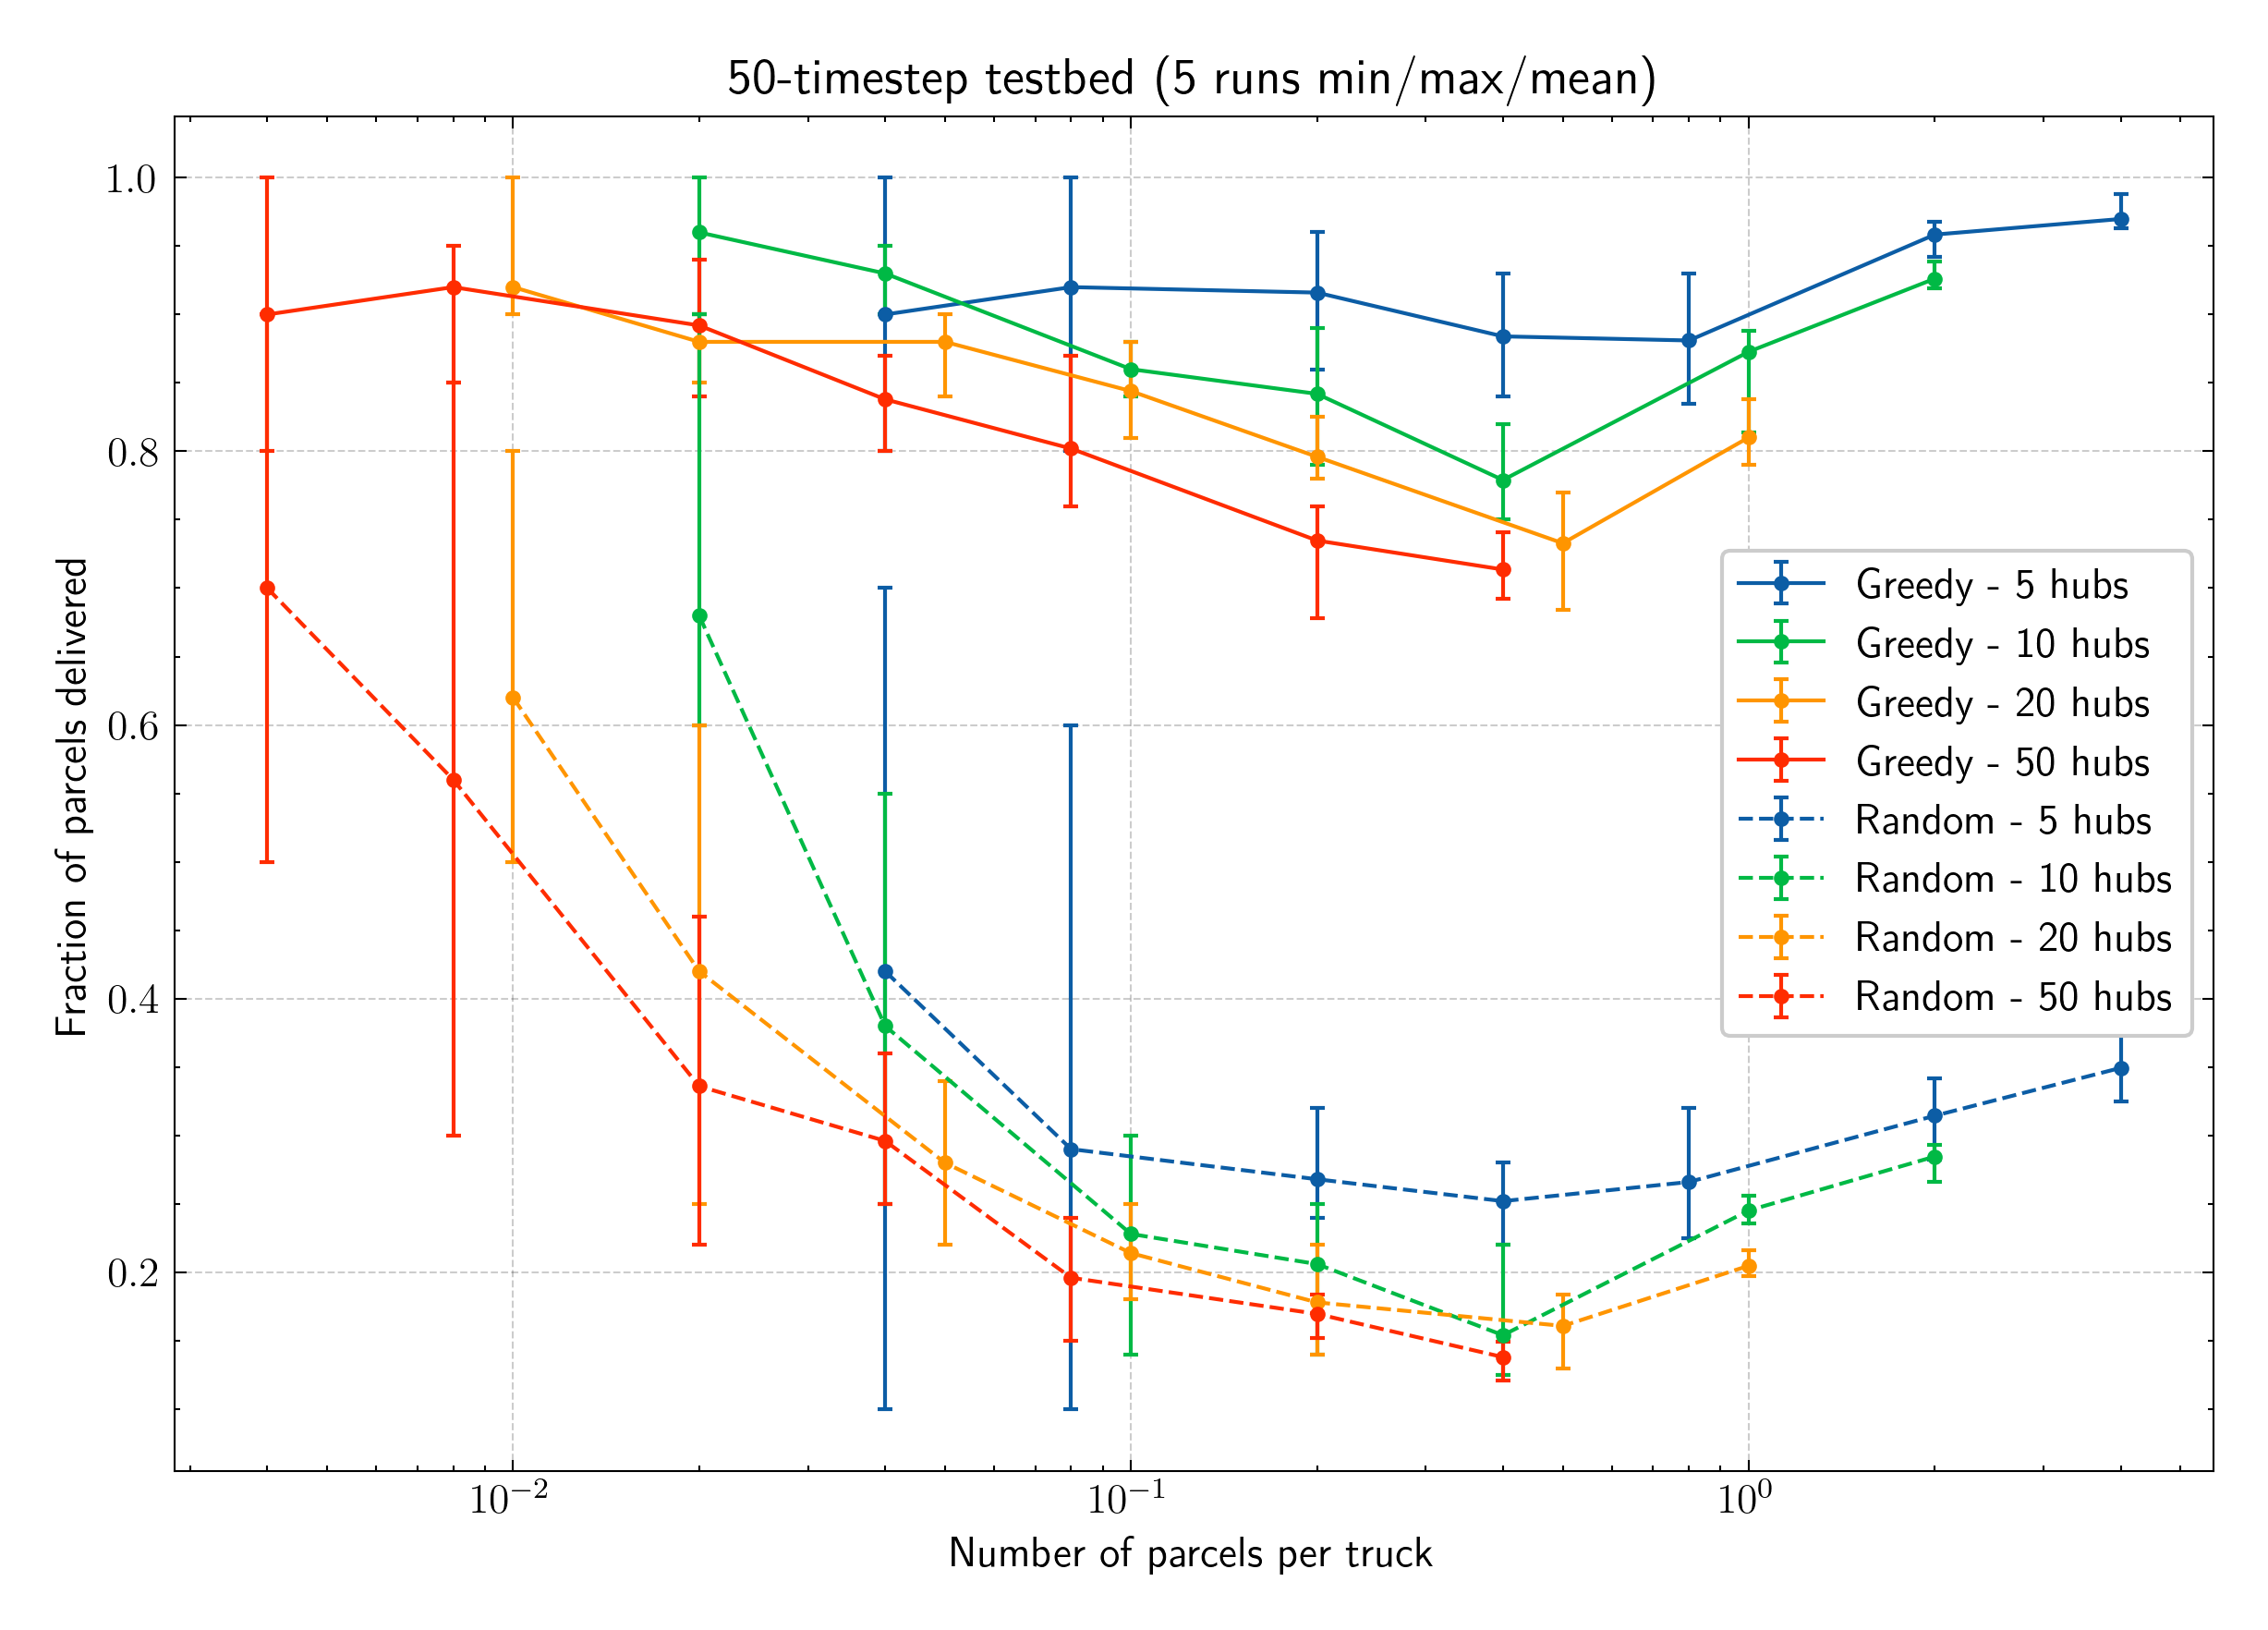

In [13]:
# Plot performances.
fig, ax = plt.subplots()
ax.set_title("50-timestep testbed (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels per truck")
ax.set_ylabel("Fraction of parcels delivered")
ax.set_xscale('log')
for i, num_hubs in enumerate(nums_hubs):
    timesteps = 50
    parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
    ax.errorbar(
        parcel_per_truck,
        np.nanmean(greedy_perf[i], 1),
        np.stack([
            np.nanmean(greedy_perf[i], 1) - np.nanmin(greedy_perf[i], 1), 
            np.nanmax(greedy_perf[i], 1) - np.nanmean(greedy_perf[i], 1)
        ]),
        fmt=f'C{i}.-',
        capsize=2,
        label=f'Greedy - {num_hubs} hubs'
    )
for i, num_hubs in enumerate(nums_hubs):
    timesteps = 50
    parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
    ax.errorbar(
        parcel_per_truck,
        np.nanmean(random_perf[i], 1),
        np.stack([
            np.nanmean(random_perf[i], 1) - np.nanmin(random_perf[i], 1), 
            np.nanmax(random_perf[i], 1) - np.nanmean(random_perf[i], 1)
        ]),
        fmt=f'C{i}.--',
        capsize=2,
        label=f'Random - {num_hubs} hubs'
    )
ax.legend()

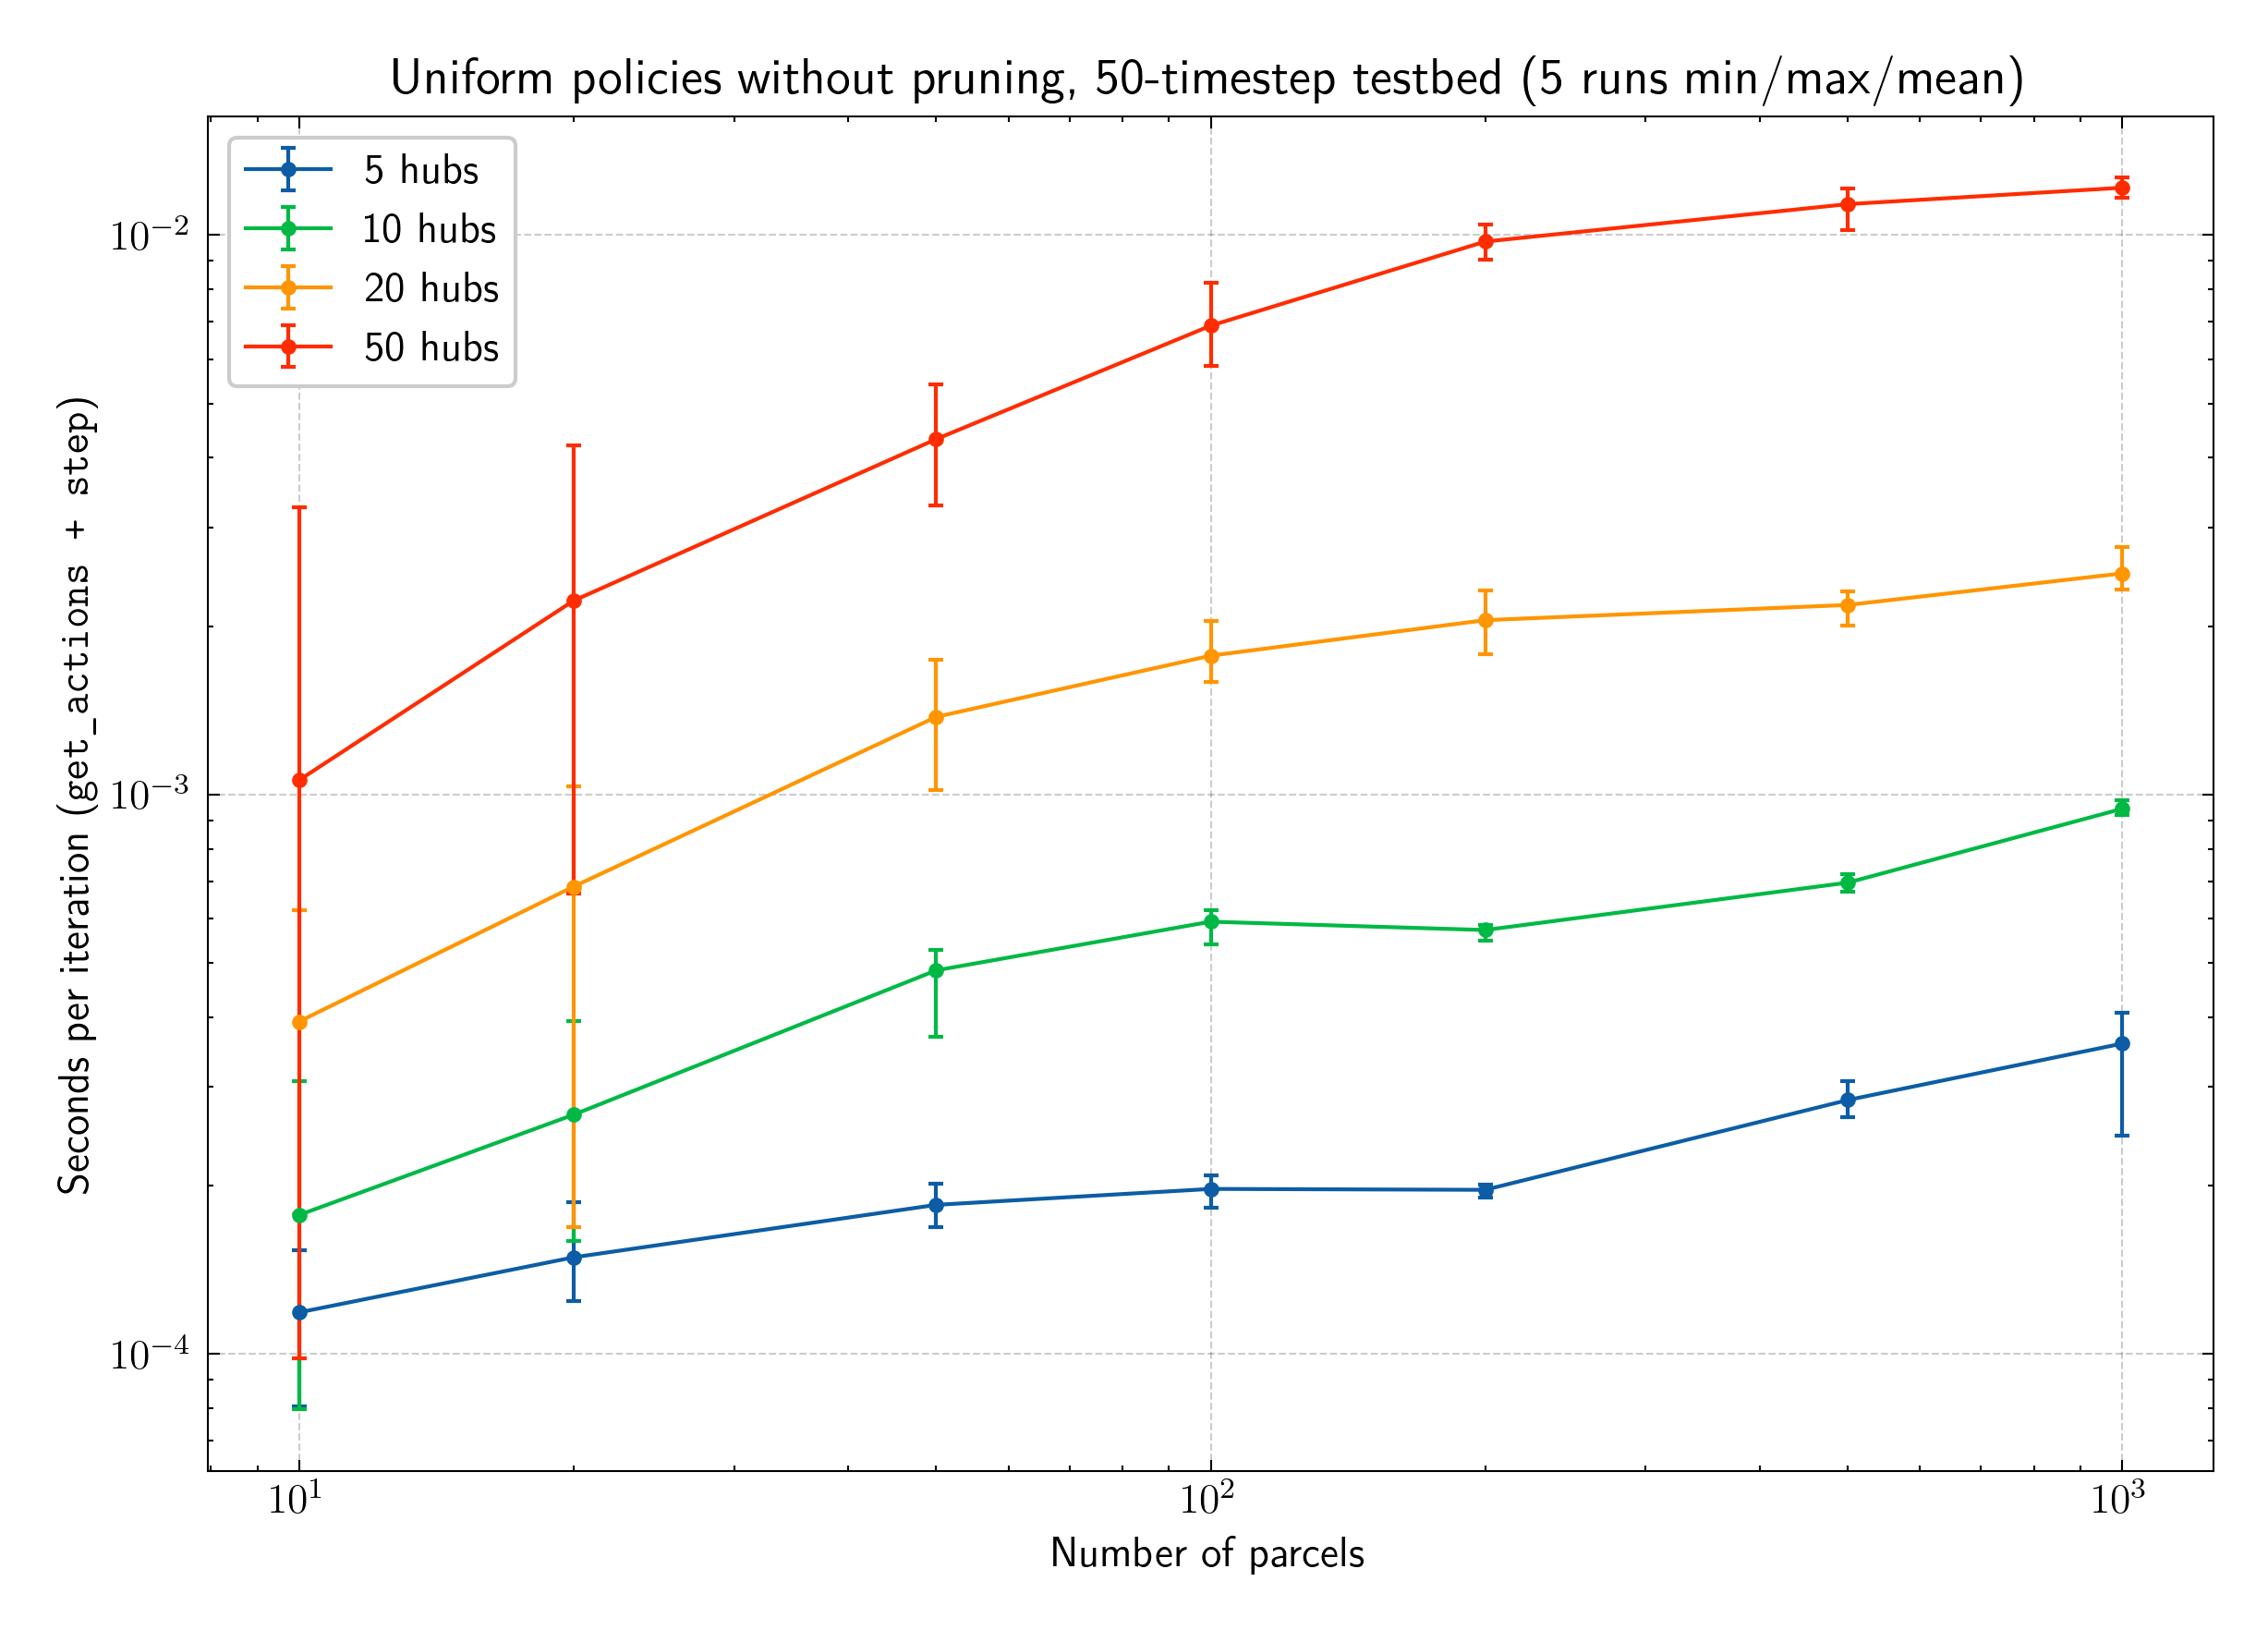

In [14]:
# Plot performances.
fig, ax = plt.subplots()
ax.set_title("Uniform policies without pruning, 50-timestep testbed (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels")
ax.set_ylabel(r"Seconds per iteration (\texttt{get_actions + step})")
ax.set_xscale('log')
ax.set_yscale('log')
times[times == 0] = np.nan
times_ = times / iterations
for i, num_hubs in enumerate(nums_hubs):
    ax.errorbar(
        nums_parcels,
        np.nanmean(times_[i], 1),
        np.stack([
            np.nanmean(times_[i], 1) - np.nanmin(times_[i], 1),
            np.nanmax(times_[i], 1) - np.nanmean(times_[i], 1)
        ]),
        fmt='.-',
        capsize=2,
        label=f'{num_hubs} hubs'
    )
ax.legend()

# Routing schemes comparison

In [19]:
# One-step vs. all-step vs. last-parcel routing (all with pruning).
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5
one_perf = np.zeros((len(nums_parcels), num_trials))
all_perf = np.zeros((len(nums_parcels), num_trials))
last_perf = np.zeros((len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_parcels in enumerate(tqdm(nums_parcels)):
  for j in tqdm(range(num_trials), leave=False):
    num_hubs = 10  # Number of depots in the network.
    timesteps = 50  # Number of time steps.
    num_trucks_per_step = num_hubs

    # Create middle-mile environment and initialize state.
    env = mdp.MiddleMileMDP(
        num_hubs=num_hubs,
        timesteps=timesteps,
        num_trucks_per_step=num_trucks_per_step,
        max_truck_duration=5,
        num_parcels=num_parcels,
        mean_route_length=10,
        unit_weights=True,
        unit_capacities=True,
    )
    initial_state, _ = env.reset(rng)

    # One-step rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, prune_parcel=False)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, parcel = env.step(parcel, truck, state, prune=False)
      deliveries += delivery

    # Record performance.
    one_perf[i, j] = deliveries / num_parcels

    # All-step rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel.
      state, parcel, _ = env.get_next_parcel(state, prune_parcel=False)
      if parcel is None:
        break

      # Route parcel.
      while parcel is not None:
        state, parcel, trucks = env.get_actions(
          state, parcel, prune_parcel=False
        )
        if parcel is None:
          break

        # Put parcel onto random truck, get next state.
        truck = rng.choice(trucks)
        state, delivery, parcel = env.step(parcel, truck, state, prune=False)
        deliveries += delivery

    # Record performance.
    all_perf[i, j] = deliveries / num_parcels

    # Last-parcel rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(
        state, prune_parcel=False, last_parcel=True
      )
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, parcel = env.step(parcel, truck, state, prune=False)
      deliveries += delivery

    # Record performance.
    last_perf[i, j] = deliveries / num_parcels

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

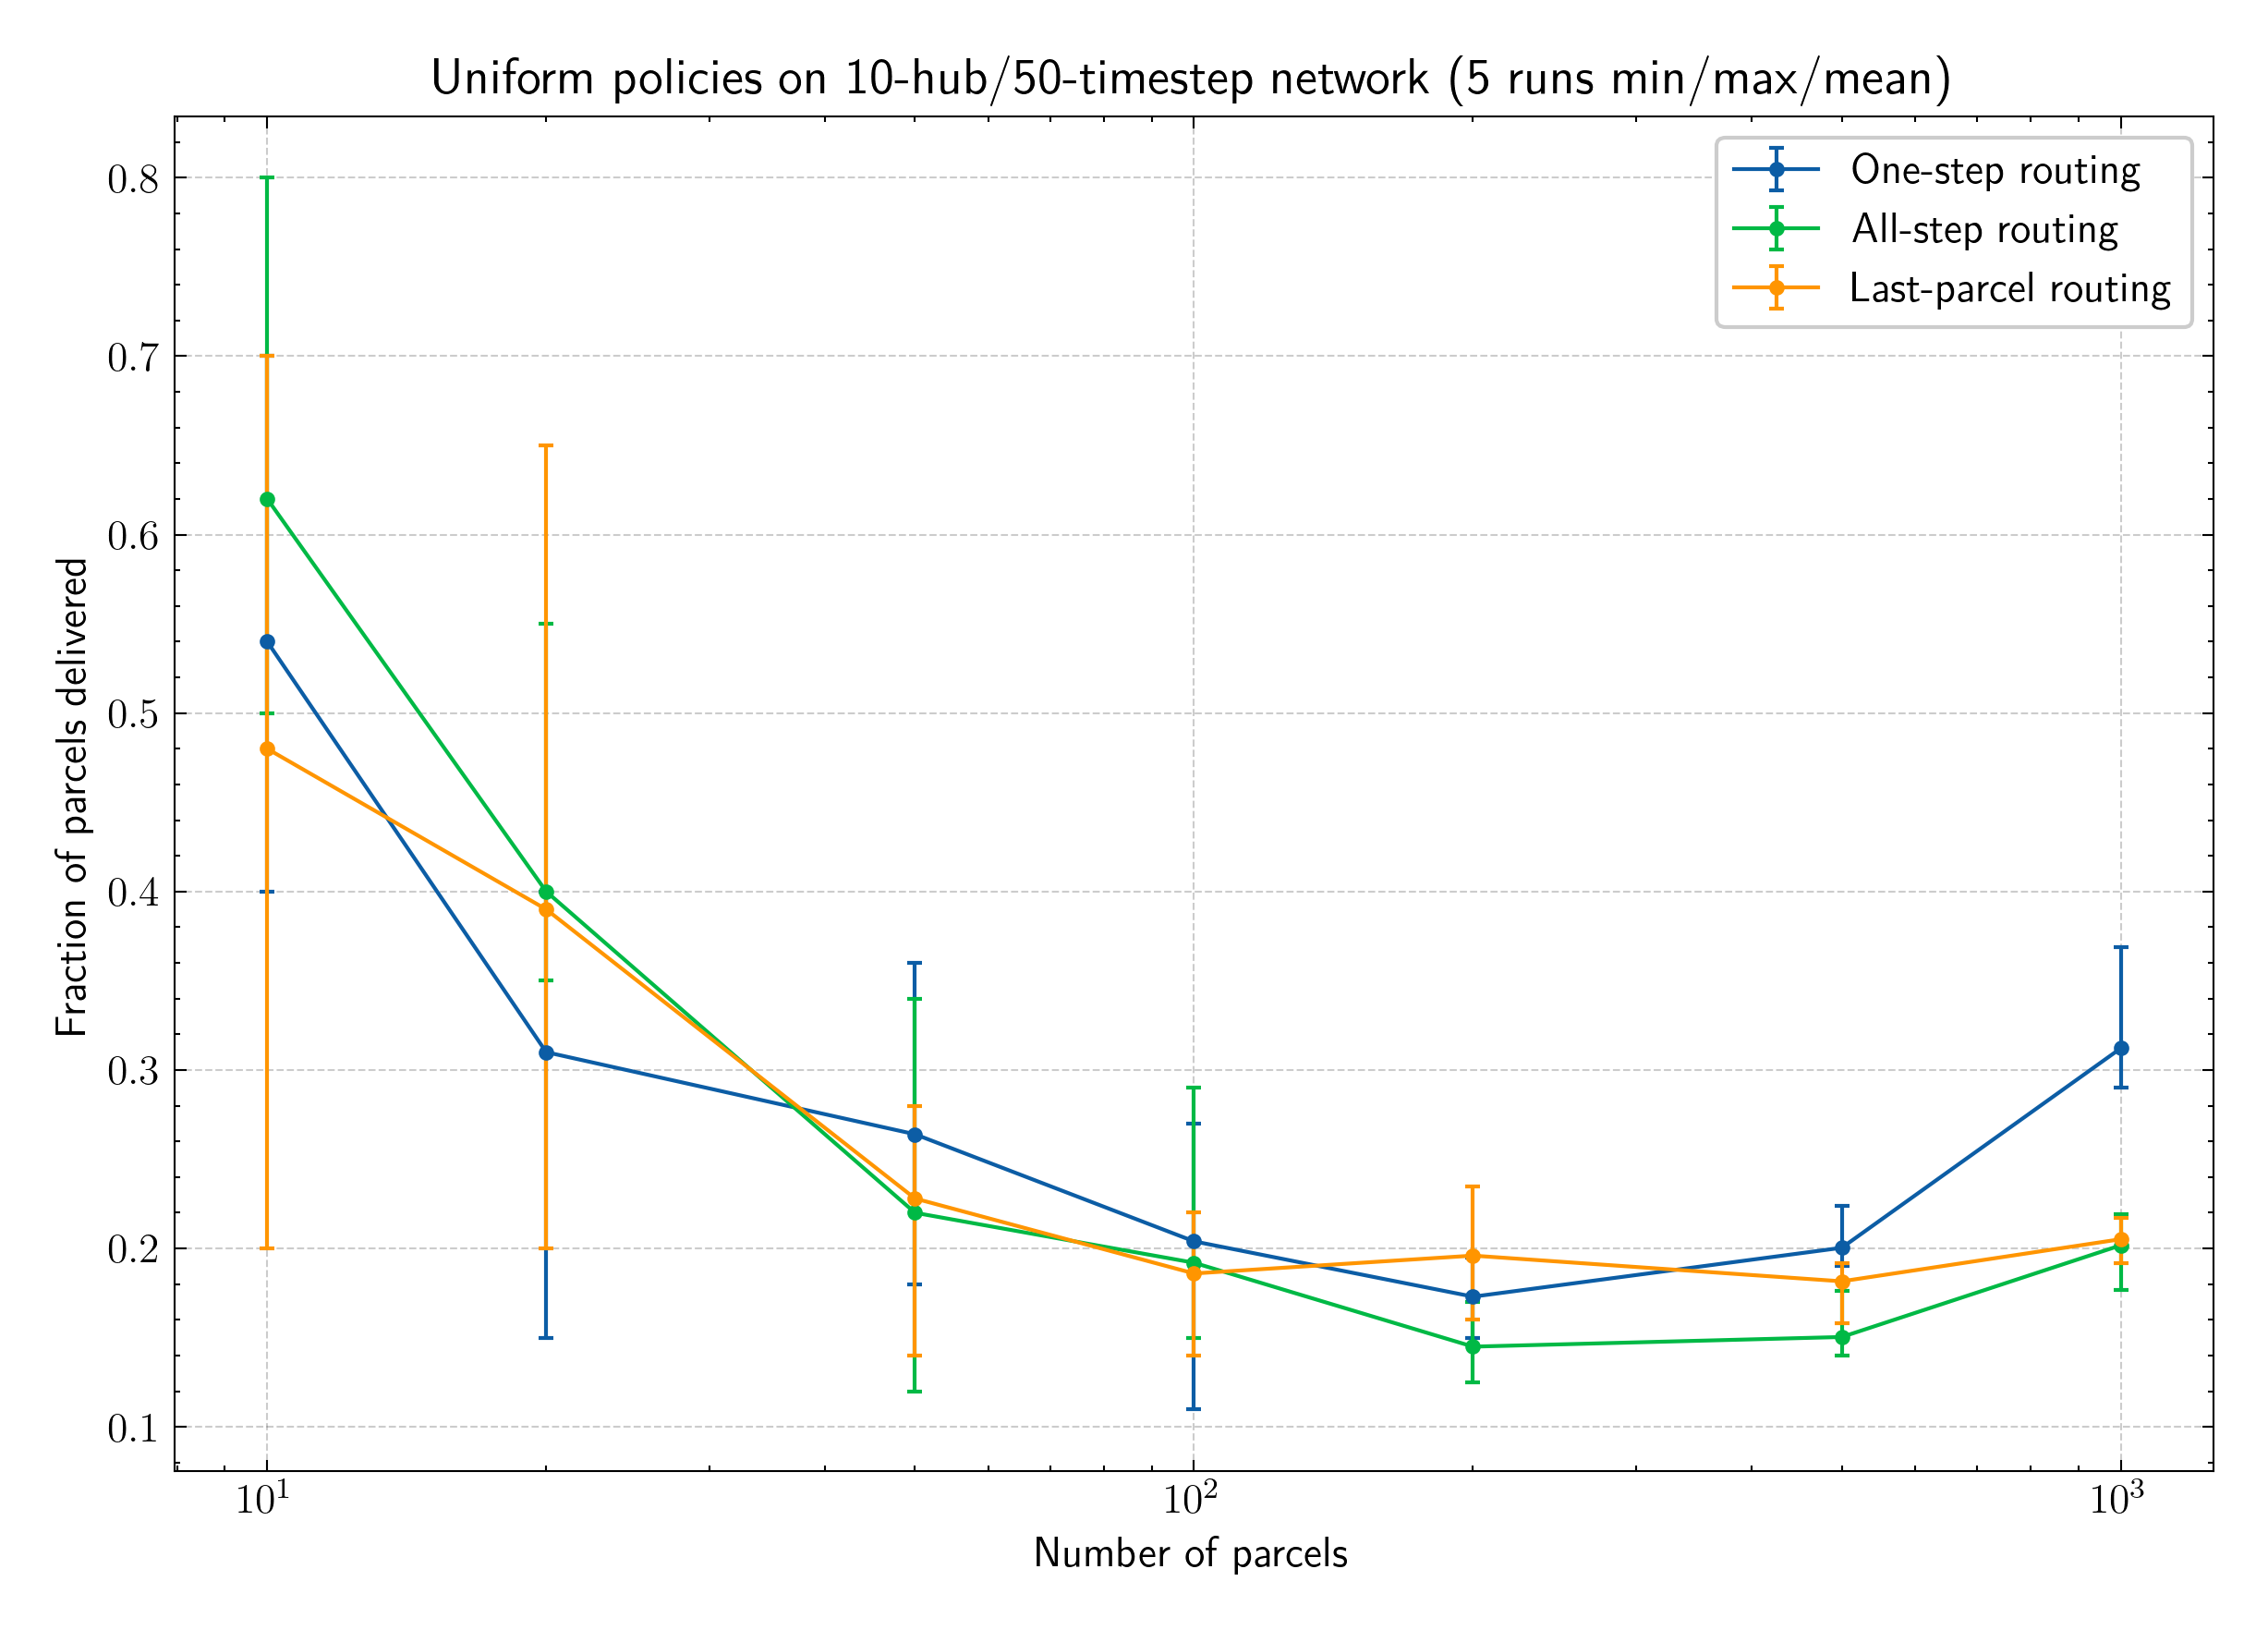

In [21]:
# Plot performances.
fig, ax = plt.subplots()
ax.set_title("Uniform policies on 10-hub/50-timestep network (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels")
ax.set_ylabel("Fraction of parcels delivered")
ax.set_xscale('log')
one_perf[one_perf == 0] = np.nan
all_perf[all_perf == 0] = np.nan
last_perf[last_perf == 0] = np.nan
ax.errorbar(
    nums_parcels,
    np.nanmean(one_perf, 1),
    np.stack([
        np.nanmean(one_perf, 1) - np.nanmin(one_perf, 1),
        np.nanmax(one_perf, 1) - np.nanmean(one_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='One-step routing'
)
ax.errorbar(
    nums_parcels,
    np.nanmean(all_perf, 1),
    np.stack([
        np.nanmean(all_perf, 1) - np.nanmin(all_perf, 1),
        np.nanmax(all_perf, 1) - np.nanmean(all_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='All-step routing'
)
ax.errorbar(
    nums_parcels,
    np.nanmean(last_perf, 1),
    np.stack([
        np.nanmean(last_perf, 1) - np.nanmin(last_perf, 1),
        np.nanmax(last_perf, 1) - np.nanmean(last_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='Last-parcel routing'
)
ax.legend()